<a href="https://colab.research.google.com/github/Myk7o/K-means-Clustering/blob/main/gmm/GMM_%2B_Boundaries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
'''
%pip install rasterio
%pip install geopandas
%pip install scikit-image
%pip install matplotlib
'''

'\n%pip install rasterio\n%pip install geopandas\n%pip install scikit-image\n%pip install matplotlib\n'

In [19]:
import os
import cv2
import numpy as np
from sklearn.mixture import GaussianMixture as GMM
from skimage.segmentation import find_boundaries
from skimage.morphology import remove_small_objects
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects
import matplotlib.patches as mpatches
from skimage.measure import label
from skimage.morphology import remove_small_objects, binary_dilation, disk
import rasterio
from rasterio.mask import mask
import geopandas as gpd


In [20]:
import psutil
import time
import threading

# Start tracking time and create the process instance
start_time = time.time()
process = psutil.Process(os.getpid())

# CPU tracking setup
cpu_samples = []
processing = True

def sample_cpu_usage():
    while processing:
        cpu_samples.append(process.cpu_percent(interval=0.1) / psutil.cpu_count())
        time.sleep(0.5)

cpu_thread = threading.Thread(target=sample_cpu_usage)
cpu_thread.start()


In [21]:
'''
from google.colab import drive
drive.mount('/content/gdrive')
'''

"\nfrom google.colab import drive\ndrive.mount('/content/gdrive')\n"

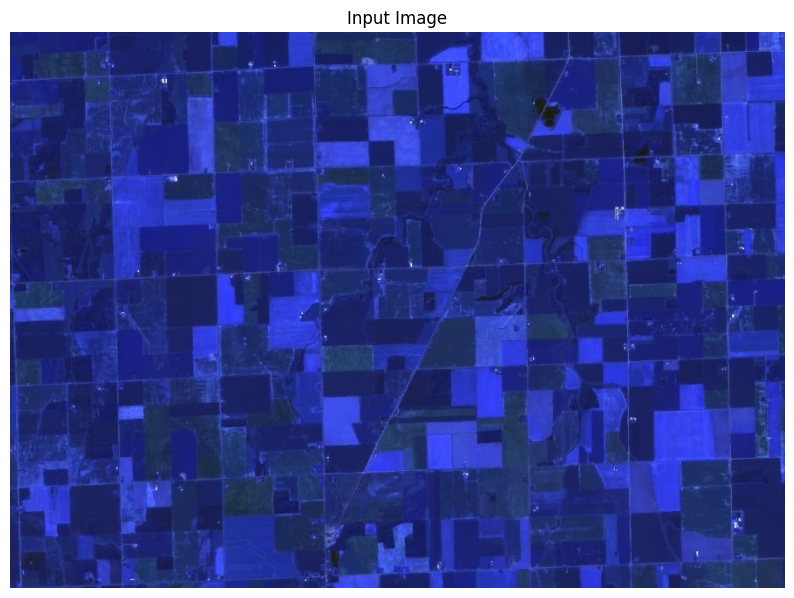

In [22]:
#loading the image
input_image_path= '/content/gdrive/MyDrive/Sentinel-2_Visioners_field_recognition/data/final_data/2_3_11_cropped.jpg'
image = cv2.imread(input_image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#Display the image
plt.figure(figsize=(10,10))
plt.imshow(image_rgb)
plt.title('Input Image')
plt.axis('off')
plt.show()

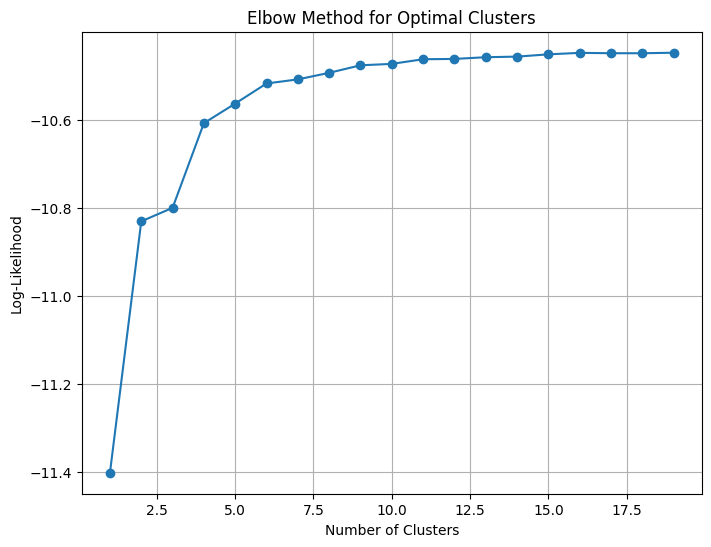

In [23]:
# Reshaping the image for clustering
pixel_values = image_rgb.reshape(-1, 3)

# Testing different numbers of clusters
n_components_range = range(1, 20)
log_likelihoods = []

for n_components in n_components_range:
    gmm = GMM(n_components=n_components, random_state=0)
    gmm.fit(pixel_values)
    log_likelihoods.append(gmm.score(pixel_values))  # Log-likelihood for each number of clusters

# Elbow Method graph
plt.figure(figsize=(8, 6))
plt.plot(n_components_range, log_likelihoods, marker='o')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Log-Likelihood")
plt.grid()


In [24]:
'''
# Intersection Over Union for a single image of an Area
def process_single_image(image_path, label_path, gmm_clusters=5):
    """Process a single image using GMM to calculate IoU and visualize."""
    # Load the raw image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image from {image_path}")
        return None

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image_rgb.shape

    # Load the labeled image
    ground_truth_mask = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
    if ground_truth_mask is None:
        print(f"Error: Unable to load labeled image from {label_path}")
        return None

    ground_truth_mask_resized = cv2.resize(ground_truth_mask, (w, h))

    # Apply Gaussian Mixture Model (GMM) for clustering
    pixel_values = image_rgb.reshape(-1, 3)
    gmm = GMM(n_components=gmm_clusters, random_state=0)
    gmm_labels = gmm.fit_predict(pixel_values)
    gmm_segmented_image = gmm_labels.reshape(h, w)

    # Extract boundaries from GMM segmentation
    gmm_boundaries = find_boundaries(gmm_segmented_image, mode='outer').astype(np.uint8)
    gmm_boundaries_inverted = 1 - gmm_boundaries  # Inverted to have black boundaries on white

    # both masks are binary
    predicted_mask_binary = gmm_boundaries_inverted
    ground_truth_mask_binary = (ground_truth_mask_resized > 0).astype(np.uint8)

    # Calculating IoU
    intersection = np.logical_and(predicted_mask_binary, ground_truth_mask_binary)
    union = np.logical_or(predicted_mask_binary, ground_truth_mask_binary)
    iou_score = np.sum(intersection) / np.sum(union)

    # Visualize the comparison
    plt.figure(figsize=(15, 5))

    # Ground Truth
    plt.subplot(1, 4, 1)
    plt.title("Ground Truth")
    plt.imshow(ground_truth_mask_binary, cmap='gray')
    plt.axis('off')

    # GMM Segmented Image
    plt.subplot(1, 4, 2)
    plt.title("GMM Segmented Image")
    plt.imshow(gmm_segmented_image, cmap='viridis')
    plt.axis('off')

    # GMM Boundaries
    plt.subplot(1, 4, 3)
    plt.title("GMM Boundaries (Inverted)")
    plt.imshow(gmm_boundaries_inverted, cmap='gray')  # Use inverted boundaries
    plt.axis('off')

    # Intersection
    plt.subplot(1, 4, 4)
    plt.title("Intersection (IoU)")
    plt.imshow(intersection, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return iou_score

# Paths for single image
image_path = '/content/gdrive/MyDrive/Sentinel-2_Visioners_field_recognition/data/final_data/500/raw/1(500).jpg'
label_path = '/content/gdrive/MyDrive/Sentinel-2_Visioners_field_recognition/data/final_data/500/labeled /1(500)_labeled.png'

# Process the image
iou_score = process_single_image(image_path, label_path, gmm_clusters=5)

# Print IoU score
if iou_score is not None:
    print(f"IoU Score for the image: {iou_score:.2f}")
'''


'\n# Intersection Over Union for a single image of an Area\ndef process_single_image(image_path, label_path, gmm_clusters=5):\n    """Process a single image using GMM to calculate IoU and visualize."""\n    # Load the raw image\n    image = cv2.imread(image_path)\n    if image is None:\n        print(f"Error: Unable to load image from {image_path}")\n        return None\n\n    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)\n    h, w, _ = image_rgb.shape\n\n    # Load the labeled image\n    ground_truth_mask = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)\n    if ground_truth_mask is None:\n        print(f"Error: Unable to load labeled image from {label_path}")\n        return None\n\n    ground_truth_mask_resized = cv2.resize(ground_truth_mask, (w, h))\n\n    # Apply Gaussian Mixture Model (GMM) for clustering\n    pixel_values = image_rgb.reshape(-1, 3)\n    gmm = GMM(n_components=gmm_clusters, random_state=0)\n    gmm_labels = gmm.fit_predict(pixel_values)\n    gmm_segmented_image

In [25]:
# Saving the overlay image
'''
output_path = '/content/gdrive/MyDrive/Sentinel-2_Visioners_field_recognition/results/predicted_boundaries_overlay_gmm.jpg'
cv2.imwrite(output_path, cv2.cvtColor(overlay_image, cv2.COLOR_RGB2BGR))
print(f"Overlay image saved to: {output_path}")
'''

'\noutput_path = \'/content/gdrive/MyDrive/Sentinel-2_Visioners_field_recognition/results/predicted_boundaries_overlay_gmm.jpg\'\ncv2.imwrite(output_path, cv2.cvtColor(overlay_image, cv2.COLOR_RGB2BGR))\nprint(f"Overlay image saved to: {output_path}")\n'

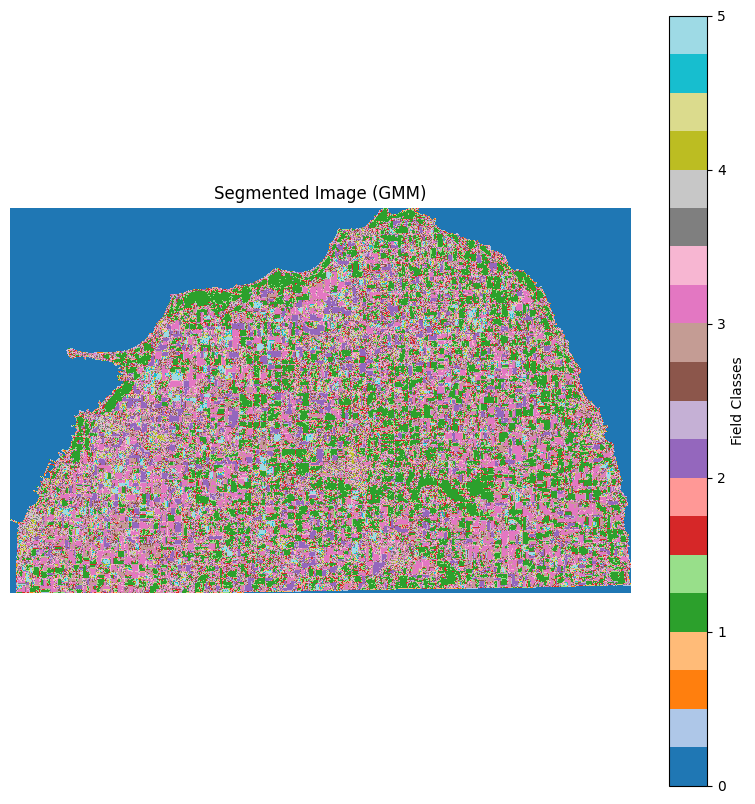

Total number of fields detected: 20136


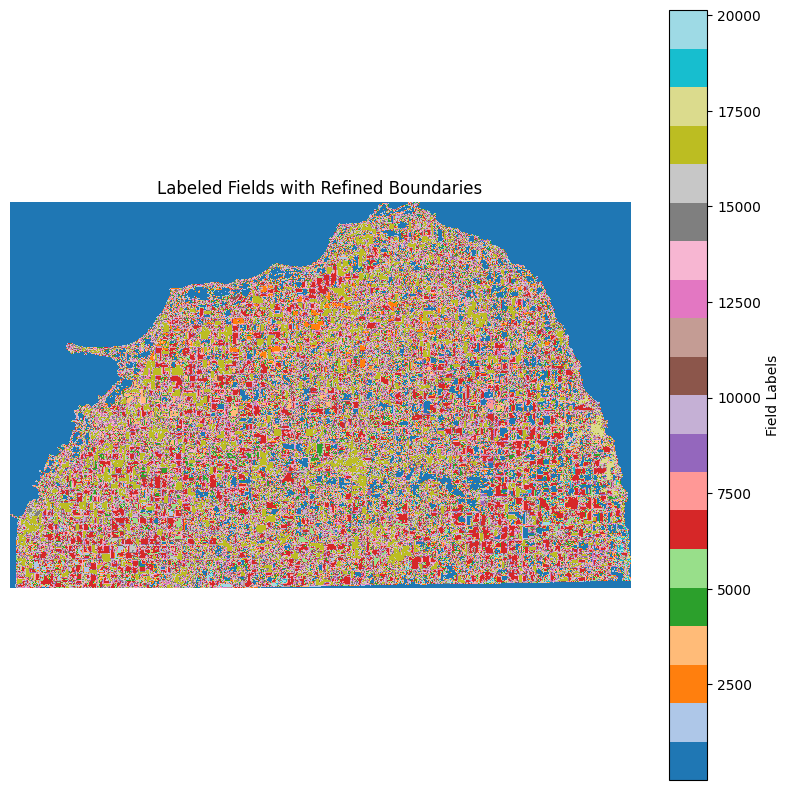

Total fields detected: 20136


In [26]:
from sklearn.mixture import GaussianMixture as GMM
from skimage.measure import label
from skimage.morphology import remove_small_objects, binary_dilation, disk
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.mask import mask
import geopandas as gpd

def combine_bands_to_rgb_and_crop(tif_file_path, county_shapefile):
    """Combine bands into an RGB image and crop to county boundaries."""
    # Load county boundary
    county_boundary = gpd.read_file(county_shapefile).to_crs("EPSG:32617")
    masked_geometries = [geom for geom in county_boundary.geometry]

    with rasterio.open(tif_file_path) as src:
        crs = src.crs
        cropped_image, transform = mask(src, masked_geometries, crop=True)

        # Read bands (assuming band 1=B02, band 2=B03, band 3=B11)
        B02 = cropped_image[0].astype(np.float32)
        B03 = cropped_image[1].astype(np.float32)
        B11 = cropped_image[2].astype(np.float32)

    return B02, B03, B11

def normalize_to_uint8(band):
    band_min = np.nanmin(band)
    band_max = np.nanmax(band)
    if band_min == band_max:
        return (band * 0).astype(np.uint8)
    normalized = (band - band_min) / (band_max - band_min) * 255
    return normalized.astype(np.uint8)

def refine_and_count_fields(B02, B03, B11, gmm_clusters=5, min_field_size=9, boundary_dilation=2):
    """Refine and count fields in the image with improved boundary handling."""
    # Combine bands into a single feature vector
    h, w = B02.shape
    pixel_values = np.stack([B02.ravel(), B03.ravel(), B11.ravel()], axis=1)

    # Apply GMM to segment the image
    gmm = GMM(n_components=gmm_clusters, random_state=0)
    gmm_labels = gmm.fit_predict(pixel_values)
    segmented_image = gmm_labels.reshape(h, w)

    # Visualize segmented image
    plt.figure(figsize=(10, 10))
    plt.imshow(segmented_image, cmap='tab20')
    plt.title("Segmented Image (GMM)")
    plt.axis('off')
    plt.colorbar(label="Field Classes")
    plt.show()

    # Count fields for each class
    total_fields = 0
    labeled_image = np.zeros_like(segmented_image, dtype=np.int32)
    for field_class in range(gmm_clusters):
        # Create a binary mask for the current field class
        class_mask = segmented_image == field_class

        # Apply boundary dilation to close small gaps
        class_mask_dilated = binary_dilation(class_mask, disk(boundary_dilation))

        # Remove small objects (noise)
        class_mask_cleaned = remove_small_objects(class_mask_dilated, min_size=min_field_size)

        # Label connected components
        labeled_class = label(class_mask_cleaned)
        labeled_image[class_mask_cleaned] = labeled_class[class_mask_cleaned] + total_fields

        # Update total fields count
        total_fields += np.max(labeled_class)

    print(f"Total number of fields detected: {total_fields}")

    # Visualize labeled fields
    plt.figure(figsize=(10, 10))
    plt.imshow(labeled_image, cmap='tab20')
    plt.title("Labeled Fields with Refined Boundaries")
    plt.axis('off')
    plt.colorbar(label="Field Labels")
    plt.show()

    return total_fields

# Paths
tif_file_path = "/content/county_bands_2_3_11.tif"
county_shapefile = "/content/gdrive/MyDrive/Sentinel-2_Visioners_field_recognition/data/shp_gmu/26063.shp"

# Combine and crop bands
B02, B03, B11 = combine_bands_to_rgb_and_crop(tif_file_path, county_shapefile)

# Normalize bands (optional, if required for visualization or processing)
B02_normalized = normalize_to_uint8(B02)
B03_normalized = normalize_to_uint8(B03)
B11_normalized = normalize_to_uint8(B11)

# Refine and count fields
field_count = refine_and_count_fields(B02_normalized, B03_normalized, B11_normalized, gmm_clusters=6, min_field_size=9, boundary_dilation=2)
print(f"Total fields detected: {field_count}")


In [27]:
# Stop CPU monitoring
processing = False
cpu_thread.join()

# Output processing time, memory usage, and average CPU usage
print(f"Processing Time: {time.time() - start_time:.2f} seconds")
print(f"Memory Usage: {process.memory_info().rss / 1024 ** 2:.2f} MB")
print(f"Average CPU Usage: {np.mean(cpu_samples):.2f}%")

Processing Time: 643.75 seconds
Memory Usage: 826.52 MB
Average CPU Usage: 65.34%


In [ ]:
'''
# IF YOU WANT TO CALCULATE THE ACREAGE OF EACH CLUSTER
def combine_bands_to_rgb_and_crop(tif_file_path, county_shapefile):
    """Combine bands into an RGB image and crop to county boundaries."""
    # Load county boundary
    county_boundary = gpd.read_file(county_shapefile).to_crs("EPSG:32617")
    masked_geometries = [geom for geom in county_boundary.geometry]

    with rasterio.open(tif_file_path) as src:
        crs = src.crs
        transform = src.transform
        cropped_image, transform = mask(src, masked_geometries, crop=True)

        # Read bands (assuming band 1=B02, band 2=B03, band 3=B11)
        B02 = cropped_image[0].astype(np.float32)
        B03 = cropped_image[1].astype(np.float32)
        B11 = cropped_image[2].astype(np.float32)

    return B02, B03, B11, transform

def normalize_to_uint8(band):
    band_min = np.nanmin(band)
    band_max = np.nanmax(band)
    if band_min == band_max:
        return (band * 0).astype(np.uint8)
    normalized = (band - band_min) / (band_max - band_min) * 255
    return normalized.astype(np.uint8)

def refine_and_count_fields(B02, B03, B11, transform, gmm_clusters=5, min_field_size=9, boundary_dilation=2):
    """Refine and count fields in the image with improved boundary handling."""
    # Combine bands into a single feature vector
    h, w = B02.shape
    pixel_values = np.stack([B02.ravel(), B03.ravel(), B11.ravel()], axis=1)

    # Apply GMM to segment the image
    gmm = GMM(n_components=gmm_clusters, random_state=0)
    gmm_labels = gmm.fit_predict(pixel_values)
    segmented_image = gmm_labels.reshape(h, w)

    # Identify and mask the water cluster (largest cluster surrounding the land)
    unique_labels, label_counts = np.unique(segmented_image, return_counts=True)
    water_cluster = unique_labels[np.argmax(label_counts)]
    water_mask = segmented_image == water_cluster
    segmented_image[water_mask] = -1  # Mask water cluster

    # Visualize segmented image
    plt.figure(figsize=(10, 10))
    plt.imshow(segmented_image, cmap='tab20')
    plt.title("Segmented Image (GMM) without Water")
    plt.axis('off')
    plt.colorbar(label="Field Classes")
    plt.show()

    # Calculate pixel area in square meters
    pixel_area_B02_B03 = 10 * 10  # 10m resolution for B02 and B03
    pixel_area_B11 = 20 * 20      # 20m resolution for B11
    pixel_area = pixel_area_B02_B03  # Using the highest resolution band for acreage

    # Count fields for each class and calculate acreage
    total_fields = 0
    field_areas = []
    labeled_image = np.zeros_like(segmented_image, dtype=np.int32)
    for field_class in range(gmm_clusters):
        if field_class == water_cluster:
            continue  # Skip water cluster

        # Create a binary mask for the current field class
        class_mask = segmented_image == field_class

        # Apply boundary dilation to close small gaps
        class_mask_dilated = binary_dilation(class_mask, disk(boundary_dilation))

        # Remove small objects (noise)
        class_mask_cleaned = remove_small_objects(class_mask_dilated, min_size=min_field_size)

        # Label connected components
        labeled_class = label(class_mask_cleaned)
        labeled_image[class_mask_cleaned] = labeled_class[class_mask_cleaned] + total_fields

        # Calculate acreage for each labeled field
        unique_labels, label_counts = np.unique(labeled_class, return_counts=True)
        class_areas = label_counts[1:] * pixel_area  # Skip background label (0)

        field_areas.append((field_class, np.sum(class_areas), len(unique_labels) - 1))  # Total area and count per class

        # Update total fields count
        total_fields += len(unique_labels) - 1

    print(f"Total number of fields detected: {total_fields}")

    # Print acreage details
    print("\nField Class Statistics:")
    total_acreage = 0
    for field_class, class_area, field_count in field_areas:
        total_acreage += class_area
        print(f"Class {field_class}: Total Acreage = {class_area:.2f} m², Field Count = {field_count}")

    print(f"\nTotal Acreage: {total_acreage:.2f} m²")

    # Visualize labeled fields
    plt.figure(figsize=(10, 10))
    plt.imshow(labeled_image, cmap='tab20')
    plt.title("Labeled Fields with Refined Boundaries")
    plt.axis('off')
    plt.colorbar(label="Field Labels")
    plt.show()

    return total_fields, total_acreage

# Paths
tif_file_path = "" # Enter the path to the file you want to process
county_shapefile = "" Enter the path to the county shapefile (any county you want to work with)

# Combine and crop bands
B02, B03, B11, transform = combine_bands_to_rgb_and_crop(tif_file_path, county_shapefile)

# Normalize bands (optional, if required for visualization or processing)
B02_normalized = normalize_to_uint8(B02)
B03_normalized = normalize_to_uint8(B03)
B11_normalized = normalize_to_uint8(B11)

# Refine and count fields
field_count, total_acreage = refine_and_count_fields(B02_normalized, B03_normalized, B11_normalized, transform, gmm_clusters=6, min_field_size=9, boundary_dilation=2)
print(f"Total fields detected: {field_count}")
print(f"Total acreage: {total_acreage:.2f} m²")
'''